In [1]:
import os
import sys
import random
import cv2
import math
import time
import numpy as np
import re
import glob
import pandas as pd


ROOT_DIR = os.path.abspath('../models/Mask_RCNN')

#import mask rcnn
sys.path.append(ROOT_DIR)

from mrcnn import utils
import mrcnn.model as modellib
from mrcnn.model import log

from mask_rcnn_config import SegmentationConfig
from mask_rcnn_config import SegmentationDataset
from mask_rcnn_config import InferenceConfig
from result import Prediction

MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Setup importan variable like dataset paths and other

The paths to retrieve and store data are defined below

In [2]:
env = "prod" 
if env == "prod":
    DATA_DIR = '/datalab'
else:
    DATA_DIR = '../data'
    
DATA_TRAIN = DATA_DIR + '/train_color/*.jpg'
DATA_TEST  = DATA_DIR + '/test/*.jpg'
MASKS_PREDICTION_PATH = DATA_DIR + '/test_masks/'

These lines below are for helpers functions to vizualize and split test set

In [3]:
from sklearn import model_selection
import matplotlib
import matplotlib.pyplot as plt
from mrcnn import visualize
import scipy.misc
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

### Preparation for training

The train data set is being splitted in train and validation, and the test set is created.
to achieve that SegmentationDataset class is used to receive the paths for images in all of
the sets. Images are not loaded to memory, it will happend only in training time with a 
generator.

In [43]:
train = glob.glob(DATA_TRAIN)
test = glob.glob(DATA_TEST)

X_train, X_val, _, _ = model_selection.train_test_split(train, train, test_size=0.3)

dataset_train = SegmentationDataset(data_dir=DATA_DIR)
dataset_train.load_cvpr_images(X_train)
dataset_train.prepare()

dataset_val = SegmentationDataset(data_dir=DATA_DIR)
dataset_val.load_cvpr_images(X_val)
dataset_val.prepare()

testset = SegmentationDataset(data_dir=DATA_DIR)
testset.load_cvpr_images(test)
testset.prepare()

config = SegmentationConfig()
config.display()

assert(len(train) > 1000)
assert(len(test) > 1000)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                22
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9

### Training

A mask R-CNN model is instantiated in training mode
`init_with` is set to 'coco' to start training from
coco learned features. it can be set to last using last
trained features

In [6]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

# Which weights to start with?
init_with = "last"  # imagenet, coco, or last
if init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])

In [7]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=5, 
            layers='heads')


Starting at epoch 15. LR=0.001

Checkpoint Path: /home/ubuntu/lab/segmentation/models/Mask_RCNN/logs/segmentationconfig20180530T2312/mask_rcnn_segmentationconfig_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
m

### Inference

Model with inference mode is instantiated and loads
last trained features.

In [8]:
inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/ubuntu/lab/segmentation/models/Mask_RCNN/logs/segmentationconfig20180530T2312/mask_rcnn_segmentationconfig_0015.h5


In [9]:
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (22,)                 min:    0.00000  max: 6273.00000  float64
gt_class_id              shape: (27,)                 min:    1.00000  max:    9.00000  int32
gt_bbox                  shape: (27, 4)               min:  205.00000  max: 1024.00000  int32
gt_mask                  shape: (1024, 1024, 27)      min:    0.00000  max:    1.00000  bool


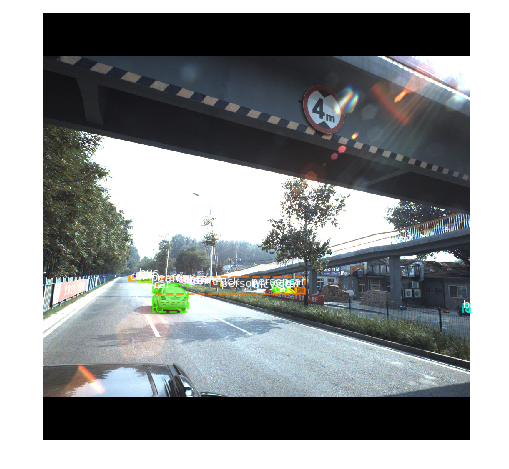

In [10]:
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

### Predict one image

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 22)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


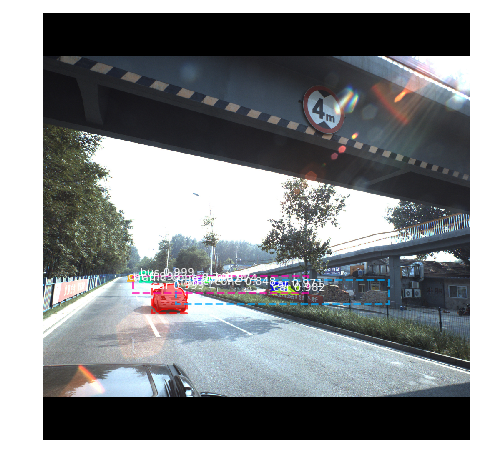

In [11]:
results = model.detect([original_image], verbose=1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

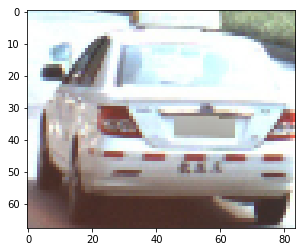

In [12]:
r_ = r['rois'][0]
plt.imshow(original_image[r_[0]:r_[2],r_[1]:r_[3], :])

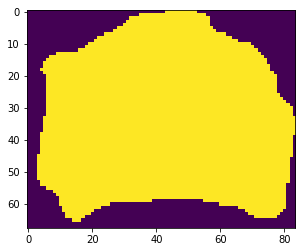

In [13]:
plt.imshow(r['masks'][:, :, 0][ r_[0]:r_[2],r_[1]:r_[3] ])

In [35]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 100)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)

    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP = 0.0
    if not r["rois"].shape[0] == 0:
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.3343020291878235


### Getting the test data results

In [44]:
prediction = Prediction(testset, MASKS_PREDICTION_PATH, data_dir=DATA_DIR, cores=8)
prediction_data = prediction.generate_results(model)

In [ ]:
results = pd.read_csv(result_path)
results.head()

#### Submision File
